In [3]:
import torchvision
import torchvision.transforms as transforms
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [4]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

Files already downloaded


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

In [6]:
classes = ('Zero', 'One', 'Two', 'Three',
           'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine')

In [7]:
trainset.train_data.size()

torch.Size([60000, 28, 28])

In [8]:
trainset.train_labels.size()

torch.Size([60000])

In [9]:
dataiter = iter(trainloader)

In [10]:
images, labels = dataiter.next()

In [11]:
images.size()

torch.Size([4, 1, 28, 28])

In [12]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

    6     1     3     7


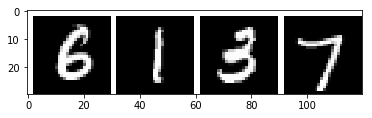

In [13]:
# print images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s'%labels[j] for j in range(4)))

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool  = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*4*4, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.cuda()

Net (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (256 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)

In [15]:
criterion = nn.CrossEntropyLoss() # use a Classification Cross-Entropy loss
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [16]:
for epoch in range(2): # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)
        
        inputs.cuda()
        labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()        
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

TypeError: FloatSpatialConvolutionMM_updateOutput received an invalid combination of arguments - got (int, torch.FloatTensor, torch.FloatTensor, torch.cuda.FloatTensor, torch.cuda.FloatTensor, torch.FloatTensor, torch.FloatTensor, long, long, int, int, int, int), but expected (int state, torch.FloatTensor input, torch.FloatTensor output, torch.FloatTensor weight, [torch.FloatTensor bias or None], torch.FloatTensor finput, torch.FloatTensor fgradInput, int kW, int kH, int dW, int dH, int padW, int padH)

In [27]:
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                          shuffle=False, num_workers=2)

Files already downloaded


('GroundTruth: ', 'Seven   Two   One  Zero')


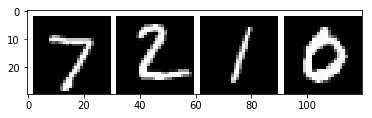

In [30]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s'%classes[labels[j]] for j in range(4)))

In [31]:
outputs = net(Variable(images))

# the outputs are energies for the 10 classes. 
# Higher the energy for a class, the more the network 
# thinks that the image is of the particular class

# So, let's get the index of the highest energy
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s'% classes[predicted[j][0]] for j in range(4)))

('Predicted: ', ' Five Eight Seven  Five')


In [32]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 7 %


In [33]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

In [34]:
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of  Zero :  5 %
Accuracy of   One :  0 %
Accuracy of   Two :  0 %
Accuracy of Three :  0 %
Accuracy of  Four :  0 %
Accuracy of  Five : 40 %
Accuracy of   Six :  0 %
Accuracy of Seven :  4 %
Accuracy of Eight : 30 %
Accuracy of  Nine :  0 %
